In [1]:
from openhsl.build.builder import HSBuilder
from matplotlib import pyplot as plt
from openhsl.hsi import HSImage
import numpy as np

## Сборка ГСИ из сырых данных

Для сборки ГСИ требуется воспользоваться классом HSBuilder.

При инициализации класса указывается путь к сырым ГС данным и формат этих данных:
- path_to_data принимает строковое представление пути к данным;
- data_type принимает строковое представление типа данных 'video' или 'image'

Далее у объекта данного класса вызывается метод build с указанием требуемых параметров сборки:

- principal_slices=False
- norm_rotation=False
- barrel_dist_norm=False
- light_norm=False
- roi=False
- flip_wavelengths=False

#### 1) Сборка из видео

1. Укажем путь и тип данных в объекте сборщика HSBuilder;
2. Вызовем метод build и укажем требуемые параметры сборки (можно не указывать, тогда они будут выставлены по-умолчанию);
3. Вернем собранное ГСИ из сборщика с помощью метода get_hsi

In [2]:
hsb_video = HSBuilder(path_to_data='test_data/builder/video/rec_2022-06-06-12-24-02.avi',
                      data_type='video')

hsb_video.build(principal_slices=40)
hsi_video = hsb_video.get_hsi()

Preprocessing frames: 100%|███████████████████████████████████████████████████████| 1001/1001 [00:07<00:00, 133.40it/s]

Wavelengths data is empty


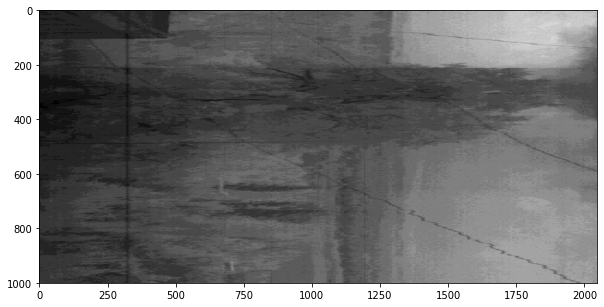

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_video[5], cmap='gray')

Как видно, исходное изображение перевернуто. Воспользуемся встроенным методом объекта HSImage и повернем ГСИ на 90 градусов против часовой стрелки

In [4]:
hsi_video.rot90()

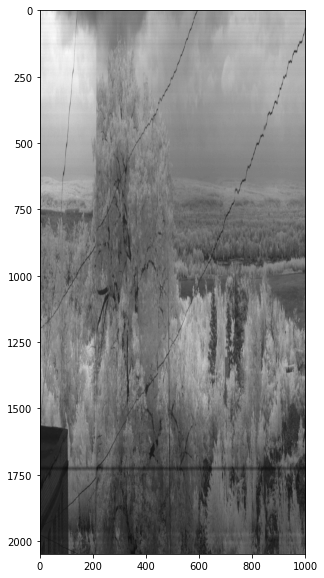

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_video[20], cmap='gray')

#### 2) Сборка из набора изображений
1. Укажем путь и тип данных в объекте сборщика HSBuilder;
2. Вызовем метод build и укажем требуемые параметры сборки;
3. Вернем собранное ГСИ из сборщика с помощью метода get_hsi

In [6]:
hsb_imgs = HSBuilder(path_to_data='test_data/builder/imgs',
                     path_to_metadata='meta_data.json',
                     data_type='images')

hsb_imgs.build(roi=True, 
               norm_rotation=True,
               light_norm=False)

hsi_imgs = hsb_imgs.get_hsi()

Preprocessing frames: 100%|██████████████████████████████████████████████████████████| 300/300 [00:29<00:00, 10.18it/s]

Wavelengths data is empty


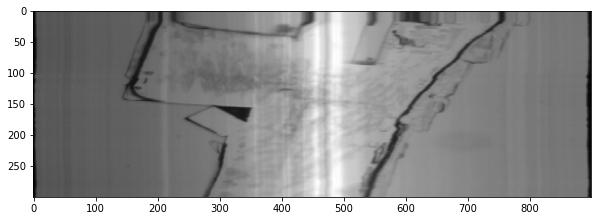

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_imgs[130], cmap='gray')

#### 3) Сборка из данных коптера (видео + gps)

1. Укажем путь и тип данных в объекте сборщика HSBuilder;
2. Вызовем метод build и укажем требуемые параметры сборки;
3. Вернем собранное ГСИ из сборщика с помощью метода get_hsi

In [8]:
hsb_uav = HSBuilder(path_to_data='test_data/builder/copter/',
                    path_to_gps='test_data/builder/copter/gps_2021-03-30.csv',
                    data_type='video')

hsb_uav.build(flip_wavelengths=True)
hsi_uav = hsb_uav.get_hsi()

Preprocessing frames: 100%|██████████████████████████████████████████████████████| 2507/2507 [00:00<00:00, 6011.98it/s]


Wavelengths data is empty


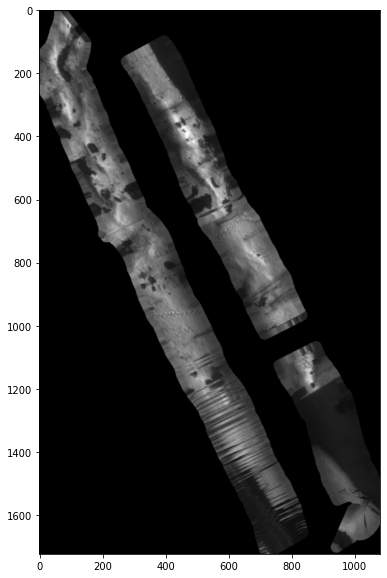

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_uav[25], cmap='gray')

## Сохранение и чтение ГСИ

при сохранении ГСИ рядом с файлом появляется файл с метаданными (в нем содержится информация о длинах волн), например:

hsi.mat
hsi_metadata.json

при чтении из файла будет произведен поиск лежащего рядом файла с метаданными и при его отсутствии поле wavelengths будет инициализировано пустым списком

#### 1) Сохранение и чтение из mat-файла

In [10]:
# Генерируем набор длин волн как стаб-данные
hsi_video.wavelengths = list(np.linspace(420, 980, 250))

hsi_video.save(path_to_data='out/hsi_video.mat',
               key='image')

hsi_video.load(path_to_data='out/hsi_video.mat',
               key='image')

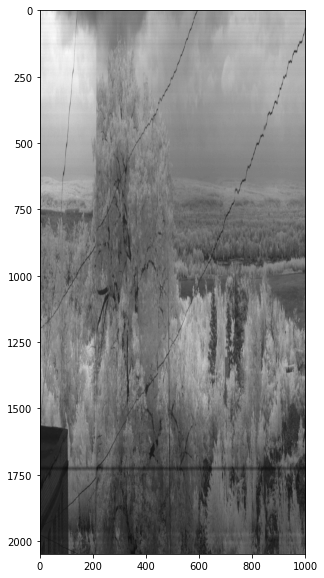

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_video[20], cmap='gray')

#### 2) Сохранение и чтение из h5-файла

In [12]:
hsi_uav.wavelengths = list(np.linspace(420, 980, 50))

hsi_uav.save(path_to_data='out/hsi_uav.h5',
             key='image')

hsi_uav.load(path_to_data='out/hsi_uav.h5',
             key='image')

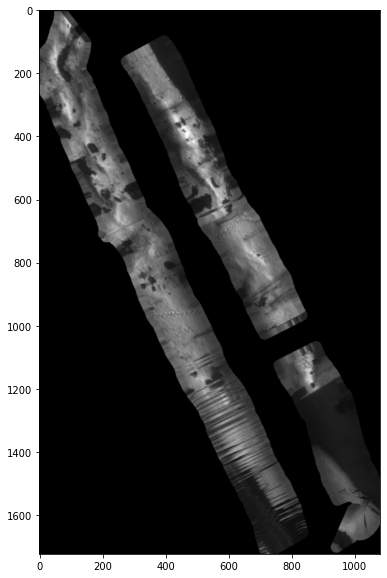

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_uav[25], cmap='gray')

#### 3) Сохранение и чтение из набора изображений (по-канально)

In [15]:
hsi_imgs.wavelengths = list(np.linspace(420, 980, 50))
hsi_imgs.save(path_to_data='out/imgs', img_format='bmp')
hsi_imgs.save_metadata(path_to_file='out/imgs_metadata.json')

hsi_imgs.load(path_to_data='out/imgs')

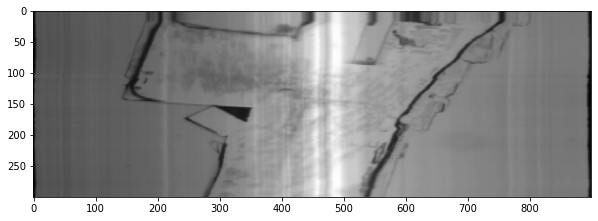

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_imgs[25], cmap='gray')

#### 4) Сохранение и чтение из npy-файла

In [9]:
hsi_video.wavelengths = list(np.linspace(420, 980, 250))

hsi_video.save(path_to_data='out/hsi_video.npy')

hsi_video.load(path_to_data='out/hsi_video.npy')

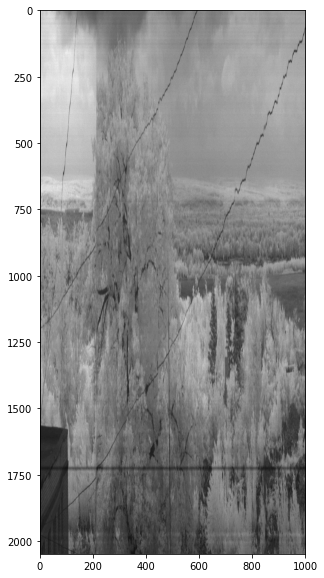

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_video[15], cmap='gray')

#### 4) Сохранение и чтение из tiff-файла

In [6]:
hsi_video.wavelengths = list(np.linspace(420, 980, 250))

hsi_video.save(path_to_data='out/hsi_video.tiff')

hsi_video.load(path_to_data='out/hsi_video.tiff')

uint8


c:\users\firsov\appdata\local\programs\python\python39\lib\site-packages\rasterio\__init__.py:341: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
c:\users\firsov\appdata\local\programs\python\python39\lib\site-packages\rasterio\__init__.py:331: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


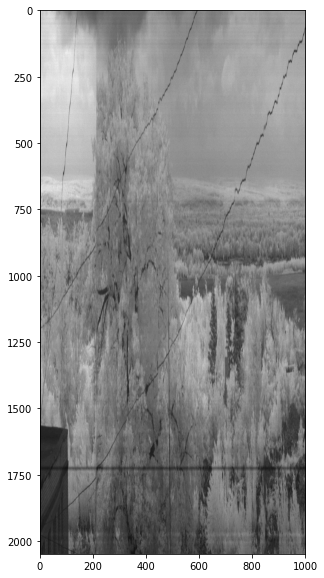

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_video[15], cmap='gray')

In [8]:
hsi_video.data.min(), hsi_video.data.max()

(16, 255)